# Plotting genes and transcripts
This should tutorial will demonstrate how to use the `skyline.tracks.genes.GeneTrack`. This is a lower level API usage than the whole plotting functions that have been used up to now.

In [1]:
from skyline import (
    figure,
    features,
    colors,
    coords
)

# Our gene track
from skyline.tracks import genes

# The grid spec holds the tracks and backends is required for the renderer
from matplotlib import gridspec
from matplotlib.backends import backend_agg

This is to display the plots within this notebook. Note that `%matplotlib notebook` does not implement any interactive plots. We have to use the display function to plot as we are not using `pyplot`. However, you can also use `matplotlib.figure.Figure.savefig` to save to file.

In [2]:
# https://ipython.readthedocs.io/en/stable/interactive/plotting.html
%matplotlib inline
from IPython.display import display

Even through we are using a lower level API component we still need the figure and a gripspec object for the number of tracks

In [3]:
# Set some figure dimentions
figure_width = 6
figure_height = 3
figure_dpi = 150

In [4]:
# Initialise the figure
gfig = figure.GenomicFigure(
    figsize=(figure_width, figure_height), dpi=figure_dpi
)
# AttributeError: 'FigureCanvasBase' object has no attribute 'get_renderer'
gfig.set_canvas(backend_agg.FigureCanvas(figure=gfig))

# Start off with a single track for our genes
tracks = gridspec.GridSpec(1, 1)

The lower level components also require a coordinates object, so we will create a function that will define one based on our gene boundaries and some padding around them.

In [5]:
def get_coord_obj(plot_genes, xpad=1000):
    """Get the chromosome coordinate object that will be used to
    map the plotting position of the genes.
    
    Parameters
    ----------
    genes : `list` of `skyline.features.SimpleTranscript`
        The gene/transcript features that we want to plot.
    pad : `int`
        The number of basepairs to the left of the first gene and right of the
        last gene that we want to extend the x-axis.
        
    Returns
    -------
    coords : `skyline.coords.ChrCoords`
        The coordinate object that we will use on the gene plot
    """
    chr_name = plot_genes[0].chr_name
    min_coord = min([i.start_pos for i in plot_genes])
    max_coord = max([i.end_pos for i in plot_genes])

    return coords.ChrCoords(chr_name, min_coord - xpad, max_coord + xpad)

The gene track that we use aligns genes in rows depending on how they overlap with each other and the size of their labels. By defaut the background for each gene row is transparant but we can for example set it to alternating colours.

In [6]:
gene_row_style = [
    dict(edgecolor='none', facecolor='none'),
    dict(edgecolor='none', facecolor=colors.CHR_LIGHT_GREY1),
]

## Manual plotting of the genes
We will first start with a very simple example where we will define some gene coordinates and plot them on a gene track

### Simple genes/transcripts

To create our genes we define some `SimpleTranscript` features. So, whilst the track that we use is called a gene track the features we place on it are called transcripts. In terms of the plotting there is no real distinction, just some coordinates that need to be plotted. But in essence the `skyline.tracks.genes.GeneTrack` will plot any region boundary it is given.

In [7]:
# All of out genes/transcripts are on the same chromosome
chr_name = '10'

# Manually create some very simple gene objects
gene1 = features.SimpleTranscript(
    chr_name, 1235000, end_pos=1235576, trans_id=1, strand=1, label="forward-gene1"
)

gene2 = features.SimpleTranscript(
    chr_name, 1235200, end_pos=1235576, trans_id=2, strand=1, label="forward-gene2"
)

gene3 = features.SimpleTranscript(
    chr_name, 1235400, end_pos=1235700, trans_id=3, strand=-1, label="reverse-gene3"
)

gene4 = features.SimpleTranscript(
    chr_name, 1235900, end_pos=1236210, trans_id=4, strand=-1, label="reverse-gene4"
)

plot_genes = [gene1, gene2, gene3, gene4]

Now we will perform our first plot. For this we will just use the default parameters.

In [8]:
# Get the coordinates obejct that we will use
chr_coords = get_coord_obj(plot_genes, xpad=100)

# Get our gene track Axes
gt = genes.GeneTrack(
    gfig, tracks[0:1], chr_coords, plot_genes,
)
gfig.add_track(gt)

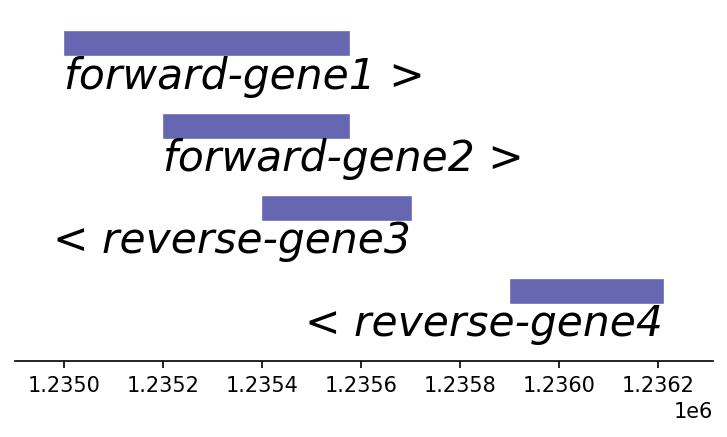

In [9]:
display(gfig)

As we will be doing multiple plots, we will need to clear the figure (or create a new one) and also need to remove the coordinate mapper from the genes as it is added by the gene track and only a single mapper can be in a feature.

In [10]:
def reset(gfig, genes):
    """Clear the figure and remove coord mappers from the genes
    
    Parameters
    ----------
    gfig : `skyline.figure.GenomicFigure`
        The figure to clear.
    genes : `list` of `skyline.features.SimpleTranscript`
        The gene/transcript features that we want to remove the
        coord object from.
    """
    gfig.clear()
    for i in genes:
        i.delete_coords_mapper()

Now we will output and demonstrate some of the parameters for `skyline.tracks.genes.GeneTrack`, there are also couple more that we will meet later.

One thing to keep in mind is that `((gene_row_pad * 2) + gene_label_height + gene_label_pad)` must be < 1 or there is no space to actually plot the gene and an error will be raised.

In [11]:
# reset the figure and the coord mapper
reset(gfig, plot_genes)

# Get the coordinates obejct that we will use
chr_coords = get_coord_obj(plot_genes, xpad=100)

# Get our gene track Axes
gt = genes.GeneTrack(
    gfig, tracks[0:1], chr_coords, plot_genes,
    # Add out alternating background colours
    gene_row_style=gene_row_style,
    # The proportion of each row that is taken up by each gene label
    gene_label_height=0.3,
    # The proportion of a gene row the is used as a gap between the
    # gene label and the gene structure
    gene_label_pad=0.2,
    # The proportion of the top and bottom of each gene row that is
    # empty space
    gene_row_pad=0.05,
)
gfig.add_track(gt)

So now we can see that the gene label size has been made smaller and we have alternating background colours. We have also added some more space between the gene label and the gene drawing (`gene_label_pad`).

You will notice in the plot below that the arrangement of the genes has changed with the forth gene now being on the top row. This is because each gene will always try to align to the topmost row and the variables it uses to do that are the gene size, the label size and a parameter called `gene_length_pad`, which is the number of base-pairs to add on to the maximum of the gene or label length. This increases the gene length and large values will spread the genes out some more. The default value is 0. So in this plot we have made the effective label width smaller so the forth gene can fit on the top row.

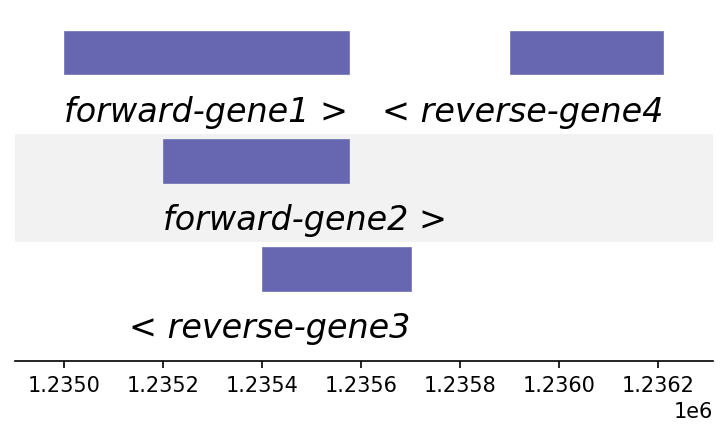

In [12]:
display(gfig)

So, lets look at some of the other things we can change. By default `skyline.tracks.genes.GeneTrack` uses `skyline.patches.genes.BlockGene` as the gene patch (plotting symbol). So, the genes are treated in a very similar way to any plotting symbol in matplotlib. And we can see out genes are very block line.

However, `skyline.patches.genes.BlockGene` allows for a directional arrow to be rendered depending on the length of the genes. In this case, our genes are below the default cutoffs of 1000 and 10000 base pairs. So, if a gene is > 1000 bp and < 10000 bp then a directional point will be rendered from 1000 bp to the end of the gene, if it is > 10000 bp then a shallower point will be rendered from 10000 bp to the end of the gene.

We can use the `len()` function to see that the lengths of our genes are below these: 

In [13]:
[len(i) for i in plot_genes]

[577, 377, 301, 311]

So, lets change that and given that our genes have a directional point on them we can remove the directional arrow on the label as well.

In [14]:
# reset the figure and the coord mapper
reset(gfig, plot_genes)

# Get the coordinates obejct that we will use
chr_coords = get_coord_obj(plot_genes, xpad=100)

# Get our gene track Axes
gt = genes.GeneTrack(
    gfig, tracks[0:1], chr_coords, plot_genes,
    # Add out alternating background colours
    gene_row_style=gene_row_style,
    # The proportion of each row that is taken up by each gene label
    gene_label_height=0.3,
    # The proportion of a gene row the is used as a gap between the
    # gene label and the gene structure
    gene_label_pad=0.2,
    # The proportion of the top and bottom of each gene row that is
    # empty space
    gene_row_pad=0.05,
    # Turn off the directional arrow on the label
    add_label_dir=False,
    # Shorten the break point arrows
    gene_patch_pointbreaks=[50]
)
gfig.add_track(gt)

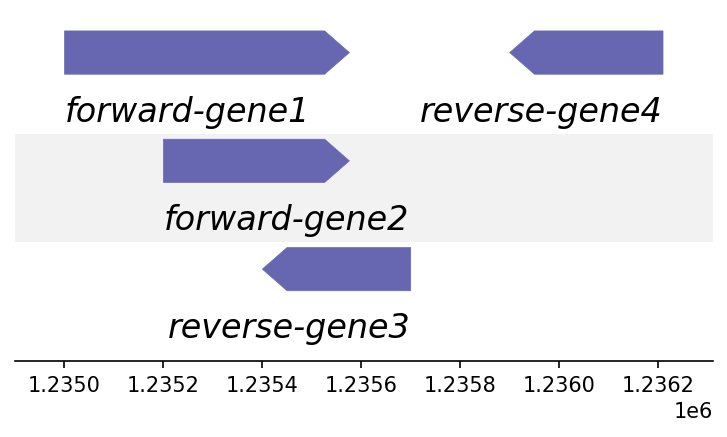

In [15]:
display(gfig)

Our genes might also look a bit nicer with a black border on them. Lets also make the labels bold, reduce our gene label padding (`gene_label_pad`) and increase `gene_row_pad` (gap between one row and another)

In [16]:
# reset the figure and the coord mapper
reset(gfig, plot_genes)

# Get the coordinates obejct that we will use
chr_coords = get_coord_obj(plot_genes, xpad=100)

# Get our gene track Axes
gt = genes.GeneTrack(
    gfig, tracks[0:1], chr_coords, plot_genes,
    # Add out alternating background colours
    gene_row_style=gene_row_style,
    # The proportion of each row that is taken up by each gene label
    gene_label_height=0.3,
    # The proportion of a gene row the is used as a gap between the
    # gene label and the gene structure
    gene_label_pad=0.1,
    # The proportion of the top and bottom of each gene row that is
    # empty space
    gene_row_pad=0.1,
    # Turn off the directional arrow on the label
    add_label_dir=False,
    # Shorten the break point arrows
    gene_patch_pointbreaks=[50],
    # Add a black border to the genes, this dict shoud be anything used
    # by `matplotlib.patches.PathPatch`
    gene_patch_style=dict(edgecolor='black', linewidth=1),
    # Make the font bold, this dict shoud be anything used
    # by `matplotlib.Text`
    gene_label_style=dict(fontweight='bold')
)
gfig.add_track(gt)

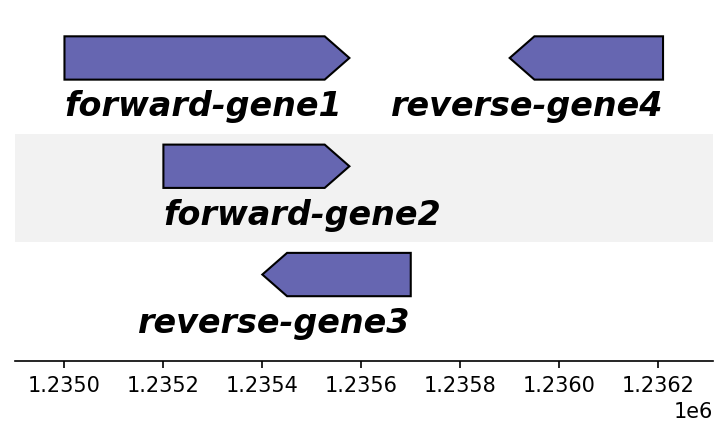

In [17]:
display(gfig)

Your genes are slightly improved now! However, what if we want to make `reverse-gene3` a different colour? For this, we can add a custom style to the `SimpleTranscript` feature. Although, please note, this will only work pre-plotting and retrospective chnges will not actuly modify the plot (i.e. not linked to eny events). 

So lets create the effect of highlighing a single gene by changing it's color and label, then changing the colour/labels for all other genes to grey.

In [18]:
gene3.gene_patch_style = dict(edgecolor="red", facecolor="yellow", linewidth=3)
gene3.gene_label_style = dict(fontweight='bold', color='black')

In [19]:
# reset the figure and the coord mapper
reset(gfig, plot_genes)
gene3.add_style(
    genes.GeneTrack.GENE_PATCH_KEY,
    dict(edgecolor="red", facecolor="yellow", linewidth=3)
)
gene3.add_style(
    genes.GeneTrack.GENE_LABEL_KEY,
    dict(fontweight='bold', color='black')
)
# Get the coordinates obejct that we will use
chr_coords = get_coord_obj(plot_genes, xpad=100)

# Get our gene track Axes
gt = genes.GeneTrack(
    gfig, tracks[0:1], chr_coords, plot_genes,
    # Add out alternating background colours
    gene_row_style=gene_row_style,
    # The proportion of each row that is taken up by each gene label
    gene_label_height=0.3,
    # The proportion of a gene row the is used as a gap between the
    # gene label and the gene structure
    gene_label_pad=0.1,
    # The proportion of the top and bottom of each gene row that is
    # empty space
    gene_row_pad=0.1,
    # Turn off the directional arrow on the label
    add_label_dir=False,
    # Shorten the break point arrows
    gene_patch_pointbreaks=[50],
    # Add a black border to the genes, this dict shoud be anything used
    # by `matplotlib.patches.PathPatch`
    gene_patch_style=dict(edgecolor='grey', facecolor='darkgrey', linewidth=1),
    # Make the font bold, this dict shoud be anything used
    # by `matplotlib.Text`
    gene_label_style=dict(color='darkgrey')
)
gfig.add_track(gt)

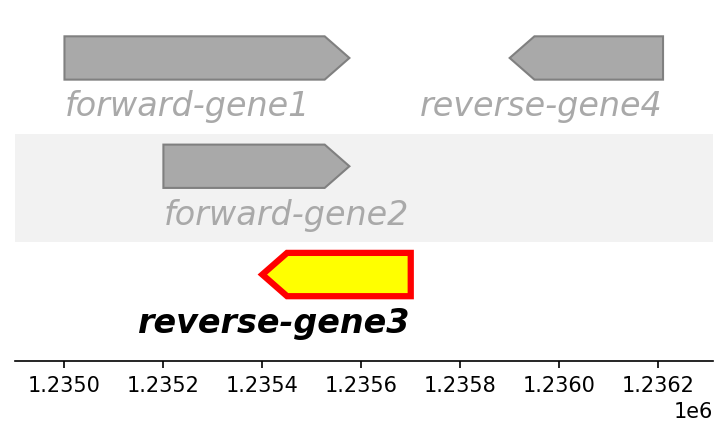

In [20]:
display(gfig)

You can also turn the labels off by setting the `gene_label_height` to 0.

In [21]:
# reset the figure and the coord mapper
reset(gfig, plot_genes)

# Get the coordinates obejct that we will use
chr_coords = get_coord_obj(plot_genes, xpad=100)

# Get our gene track Axes
gt = genes.GeneTrack(
    gfig, tracks[0:1], chr_coords, plot_genes,
    # Add out alternating background colours
    gene_row_style=gene_row_style,
    # The proportion of each row that is taken up by each gene label
    gene_label_height=0,
    # The proportion of a gene row the is used as a gap between the
    # gene label and the gene structure
    gene_row_pad=0.1,
    # Turn off the directional arrow on the label
    gene_patch_pointbreaks=[50],
    # Add a black border to the genes, this dict shoud be anything used
    # by `matplotlib.patches.PathPatch`
    gene_patch_style=dict(edgecolor='grey', facecolor='darkgrey', linewidth=1),
)
gfig.add_track(gt)

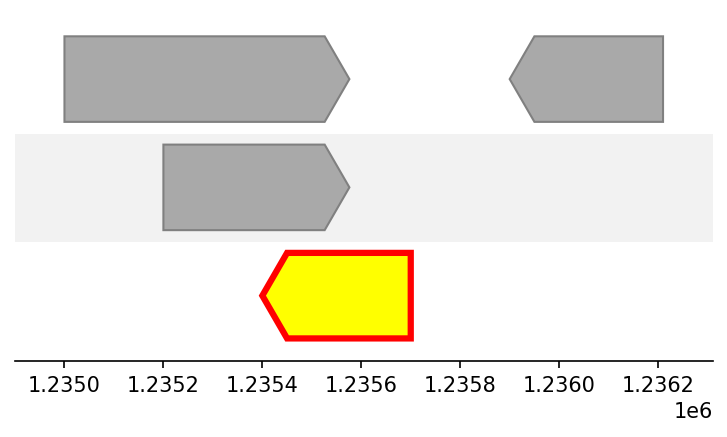

In [22]:
display(gfig)

### Complex genes/transcripts
We have seen the genes/transcripts represented by block arrow and labels. We have also seen the effect of changing various parameters. However, we can go a bit further and represent transcripts in terms of their intron/exon struction.

We will once again, define these manually, using `skyline.features.Exon` and `skyline.features.ExonTranscript` rather than `skyline.features.SimpleTranscript`.

This is shown below.

In [23]:
# All of our genes/transcripts are on the same chromosome
chr_name = '10'

# It is easier to pre-create exons and assign to the genes
exon1 = features.Exon(chr_name, 1235000, end_pos=1235300)
exon2 = features.Exon(chr_name, 1235200, end_pos=1235300)
exon3 = features.Exon(chr_name, 1235400, end_pos=1235576)
exon4 = features.Exon(chr_name, 1235400, end_pos=1235550, strand=-1)
exon5 = features.Exon(chr_name, 1235650, end_pos=1235700, strand=-1)
exon6 = features.Exon(chr_name, 1235900, end_pos=1236000, strand=-1)
exon7 = features.Exon(chr_name, 1236050, end_pos=1236100, strand=-1)
exon8 = features.Exon(chr_name, 1236150, end_pos=1236210, strand=-1)

# Manually create some very simple gene objects
gene1 = features.ExonTranscript(
    [exon1, exon3], label="forward-gene1"
)

# If we are re-using an exon definition make sure it is a copy
# so we do not get any errors when coordinate mappers are added
gene2 = features.ExonTranscript(
    [exon2, exon3.copy()], label="forward-gene2"
)

gene3 = features.ExonTranscript(
    [exon4, exon5], strand=-1, label="reverse-gene3"
)

gene4 = features.ExonTranscript(
    [exon6, exon7, exon8], strand=-1, label="reverse-gene4"
)

plot_genes = [gene1, gene2, gene3, gene4]

In [24]:
print(exon3 == exon3.copy())

False


In [25]:
# Have a look at some
print(gene1)
print(gene4)

<ExonTranscript(10:1235000-1235576|1, label=forward-gene1, trans_id=, n_exons=2, biotype=None)>
<ExonTranscript(10:1235900-1236210|-1, label=reverse-gene4, trans_id=, n_exons=3, biotype=None)>


In [26]:
# reset the figure and the coord mapper
reset(gfig, plot_genes)

# Get the coordinates obejct that we will use
chr_coords = get_coord_obj(plot_genes, xpad=100)

# Get our gene track Axes
gt = genes.GeneTrack(
    gfig, tracks[0:1], chr_coords, plot_genes,
    # Add out alternating background colours
    gene_row_style=gene_row_style,
    # The proportion of each row that is taken up by each gene label
    gene_label_height=0.3,
    # The proportion of a gene row the is used as a gap between the
    # gene label and the gene structure
    gene_label_pad=0.1,
    # The proportion of the top and bottom of each gene row that is
    # empty space
    gene_row_pad=0.1,
    # Turn off the directional arrow on the label
    add_label_dir=False,
    # Shorten the break point arrows
    gene_patch_pointbreaks=[50],
    # Add a black border to the genes, this dict shoud be anything used
    # by `matplotlib.patches.PathPatch`
    gene_patch_style=dict(edgecolor='black', linewidth=1),
    # Make the font bold, this dict shoud be anything used
    # by `matplotlib.Text`
    gene_label_style=dict(fontweight='bold')
)
gfig.add_track(gt)

We can see that even when we use the more complex gene definitions our plot looks no different. This is because of the value of the gene_patch parameter. This defaults to `skyline.patches.genes.BlockGene`. In order to make the most of our more complex definitions we need to use a patch that understands them, this is the `skyline.patches.genes.ExonGene` patch. 

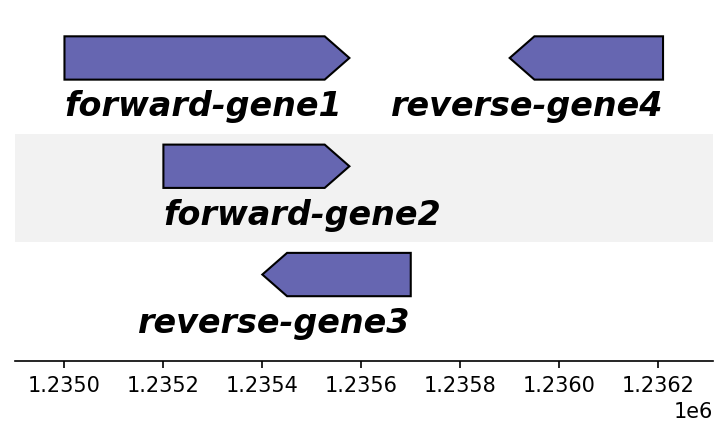

In [27]:
display(gfig)

In [28]:
from skyline.patches import genes as gp

In [29]:
# reset the figure and the coord mapper
reset(gfig, plot_genes)

# Get the coordinates obejct that we will use
chr_coords = get_coord_obj(plot_genes, xpad=100)

# Get our gene track Axes
gt = genes.GeneTrack(
    gfig, tracks[0:1], chr_coords, plot_genes,
    # Add out alternating background colours
    gene_row_style=gene_row_style,
    # The proportion of each row that is taken up by each gene label
    gene_label_height=0.3,
    # The proportion of a gene row the is used as a gap between the
    # gene label and the gene structure
    gene_label_pad=0.1,
    # The proportion of the top and bottom of each gene row that is
    # empty space
    gene_row_pad=0.1,
    # Add a black border to the genes, this dict shoud be anything used
    # by `matplotlib.patches.PathPatch`
    gene_patch_style=dict(edgecolor='black', linewidth=1),
    # Make the font bold, this dict shoud be anything used
    # by `matplotlib.Text`
    gene_label_style=dict(fontweight='bold'),
    # This understands the inron/exon structure
    gene_patch=gp.ExonGene
)
gfig.add_track(gt)

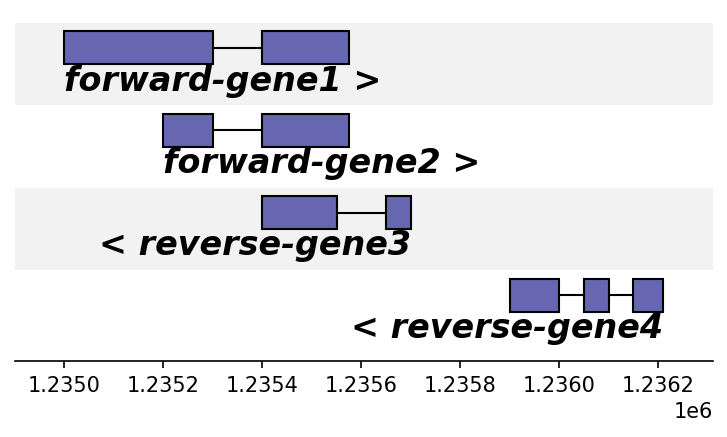

In [30]:
display(gfig)

The simple examples above have demonstrated quite a lot of the functionallity of the gene track. However, there are a couple more features to show, namely, the minimum number of gene rows and single stranded plotting. These are demonstrated in the plotting sequence below

In [31]:
from skyline.tracks import linkers

In [32]:
# reset the figure and the coord mapper
reset(gfig, plot_genes)

# Start off with a single track for our genes
tracks = gridspec.GridSpec(7, 1)

# Even though we only have a couple of genes we want to add some empty rows
min_gene_rows=4

# Get the coordinates obejct that we will use
chr_coords = get_coord_obj(plot_genes, xpad=100)

# Get our gene track Axes
gtf = genes.GeneTrack(
    gfig, tracks[0:3], chr_coords, plot_genes,
    # Add out alternating background colours
    gene_row_style=gene_row_style,
    # The proportion of each row that is taken up by each gene label
    gene_label_height=0.3,
    # The proportion of a gene row the is used as a gap between the
    # gene label and the gene structure
    gene_label_pad=0.1,
    # The proportion of the top and bottom of each gene row that is
    # empty space
    gene_row_pad=0.1,
    # Add a black border to the genes, this dict shoud be anything used
    # by `matplotlib.patches.PathPatch`
    gene_patch_style=dict(edgecolor='black', linewidth=1),
    # Make the font bold, this dict shoud be anything used
    # by `matplotlib.Text`
    gene_label_style=dict(fontweight='bold'),
    # This understands the inron/exon structure
    gene_patch=gp.ExonGene,
    # Tell the gene track to add more rows
    min_gene_rows=min_gene_rows,
    # Only plot the forward strand
    plot_strand=1
)
# Remove the x-axis
gtf.xaxis.set_visible(False)
gtf.spines['bottom'].set_visible(False)

rt = linkers.CenterRulerTrack(
    gfig, tracks[3:4], chr_coords, unit_text_style=dict(ha='left', va='center')
)

# Get our gene track Axes
gtr = genes.GeneTrack(
    gfig, tracks[4:], chr_coords, plot_genes,
    # Add out alternating background colours
    gene_row_style=gene_row_style,
    # The proportion of each row that is taken up by each gene label
    gene_label_height=0.3,
    # The proportion of a gene row the is used as a gap between the
    # gene label and the gene structure
    gene_label_pad=0.1,
    # The proportion of the top and bottom of each gene row that is
    # empty space
    gene_row_pad=0.1,
    # Add a black border to the genes, this dict shoud be anything used
    # by `matplotlib.patches.PathPatch`
    gene_patch_style=dict(edgecolor='black', linewidth=1),
    # Make the font bold, this dict shoud be anything used
    # by `matplotlib.Text`
    gene_label_style=dict(fontweight='bold'),
    # This understands the inron/exon structure
    gene_patch=gp.ExonGene,
    # Tell the gene track to add more rows
    min_gene_rows=min_gene_rows,
    # Only plot the forward strand
    plot_strand=-1
)
gtr.xaxis.set_visible(False)
gtr.spines['bottom'].set_visible(False)
# gtr.spines['top'].set_visible(True)

gfig.add_track(gtf)
gfig.add_track(rt)
gfig.add_track(gtr)

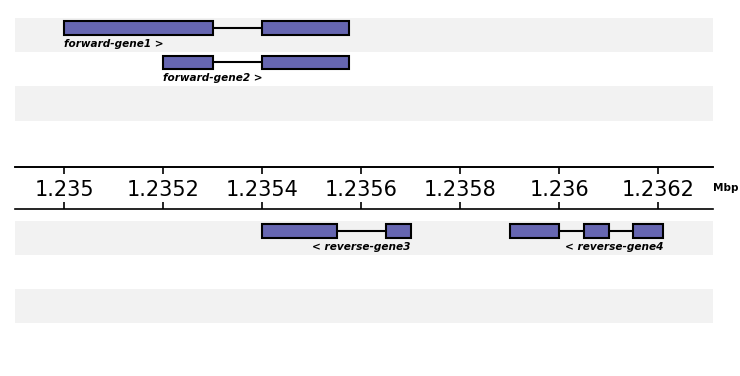

In [33]:
display(gfig)

## Plotting gene regions
In the examples above we have manually created genes and plotted them. However, it would be time consuming to manually create whole regions. Luckily, we do not have to as there is some limited support for connecting to Ensembl using their REST API, and using that data to plot the genes with in a region.

We will use the BRCAII region to demonstrate this

In [34]:
from skyline import ensembl

In [35]:
rc = ensembl.get_human_b37_rest_client()

In [36]:
flank = 1000000
brca2_locus = ('13', 32315086, 32400268)

brca2_genes = ensembl.get_genes_within(
    rc, brca2_locus[0], brca2_locus[1] - flank, brca2_locus[1] + flank,
    # Setting canonical to True will only return the single canonical
    # transcript for each gene. This is probably what we want for a
    # region plot
    canonical=True
)

If we look at the returned list we can see all the canonical transcripts in the region. The label is the ID that will be plotted but we can also see that trans_id is set to the ensembl gene ID and not a transcript ID. This is intentional, if we called canonical=False, then this would be the true ensembl transcript ID.

In [37]:
# Lets have a look at the genes
for i in brca2_genes:
    print(i)

<ExonTranscript(13:32605437-32870794|1, label=FRY, trans_id=ENSG00000073910, n_exons=61, biotype=protein_coding)>
<ExonTranscript(13:33160564-33352157|1, label=PDS5B, trans_id=ENSG00000083642, n_exons=35, biotype=protein_coding)>
<ExonTranscript(13:31774073-31906413|1, label=B3GALTL, trans_id=ENSG00000187676, n_exons=15, biotype=protein_coding)>
<ExonTranscript(13:32524296-32527578|1, label=EEF1DP3, trans_id=ENSG00000229715, n_exons=1, biotype=retained_intron)>
<ExonTranscript(13:33006930-33112936|-1, label=N4BP2L2, trans_id=ENSG00000244754, n_exons=10, biotype=protein_coding)>
<ExonTranscript(13:32889617-32973805|1, label=BRCA2, trans_id=ENSG00000139618, n_exons=28, biotype=protein_coding)>
<ExonTranscript(13:32313679-32377009|1, label=RXFP2, trans_id=ENSG00000133105, n_exons=18, biotype=protein_coding)>
<ExonTranscript(13:31456978-31506743|-1, label=TEX26-AS1, trans_id=ENSG00000224743, n_exons=4, biotype=antisense)>
<ExonTranscript(13:31506840-31549639|1, label=TEX26, trans_id=ENSG00

In [38]:
# reset the figure and the coord mapper
reset(gfig, brca2_genes)

# Initialise the figure
gfig = figure.GenomicFigure(
    figsize=(figure_width, figure_height), dpi=figure_dpi
)
# AttributeError: 'FigureCanvasBase' object has no attribute 'get_renderer'
gfig.set_canvas(backend_agg.FigureCanvas(figure=gfig))

# Start off with a single track for our genes
tracks = gridspec.GridSpec(1, 1)

# Get the coordinates obejct that we will use
chr_coords = get_coord_obj(brca2_genes, xpad=10000)

# Get our gene track Axes
gt = genes.GeneTrack(
    gfig, tracks[0:1], chr_coords, brca2_genes,
    gene_row_style=gene_row_style,
    gene_label_height=0.3,
    gene_label_pad=0.1,
    gene_row_pad=0.1,
    gene_patch_style=dict(linewidth=0.5),
    gene_label_style=dict(fontweight='bold'),
    gene_patch=gp.ExonGene,
    # As this is quite crowded we have added some padding to
    # the gene lengths to aid track placement
    gene_length_pad=1000,
)
gfig.add_track(gt)

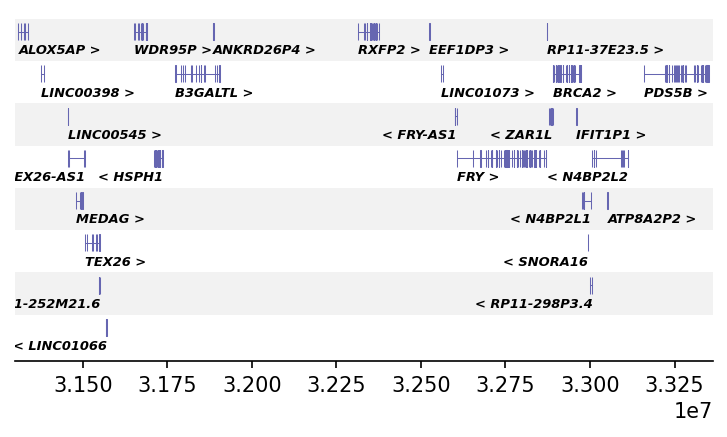

In [39]:
display(gfig)

## Plotting all the transcripts of a gene
We can also focus on a single gene and plot all of it's transcripts. If we focus on BRCA2 above.

In [40]:
brca2_trans = ensembl.get_gene_transcripts(rc, "ENSG00000139618")

Now if we have a look at them, we can see that the trans ID is indeed set to an ensembl transcript ID.

In [41]:
for i in brca2_trans:
    print(i)

<ExonTranscript(13:32889611-32973347|1, label=BRCA2-001, trans_id=ENST00000380152, n_exons=27, biotype=protein_coding)>
<ExonTranscript(13:32889642-32907428|1, label=BRCA2-003, trans_id=ENST00000530893, n_exons=10, biotype=protein_coding)>
<ExonTranscript(13:32945108-32953632|1, label=BRCA2-005, trans_id=ENST00000528762, n_exons=4, biotype=nonsense_mediated_decay)>
<ExonTranscript(13:32953977-32972409|1, label=BRCA2-002, trans_id=ENST00000470094, n_exons=6, biotype=nonsense_mediated_decay)>
<ExonTranscript(13:32970946-32972585|1, label=BRCA2-006, trans_id=ENST00000533776, n_exons=2, biotype=retained_intron)>
<ExonTranscript(13:32889617-32973805|1, label=BRCA2-201, trans_id=ENST00000544455, n_exons=28, biotype=protein_coding)>


In [42]:
# reset the figure and the coord mapper
reset(gfig, brca2_trans)

# Initialise the figure
gfig = figure.GenomicFigure(
    figsize=(figure_width, figure_height), dpi=figure_dpi
)
# AttributeError: 'FigureCanvasBase' object has no attribute 'get_renderer'
gfig.set_canvas(backend_agg.FigureCanvas(figure=gfig))

# Start off with a single track for our genes
tracks = gridspec.GridSpec(1, 1)

# Get the coordinates obejct that we will use
chr_coords = get_coord_obj(brca2_trans, xpad=30000)

# Get our gene track Axes
gt = genes.GeneTrack(
    gfig, tracks[0:1], chr_coords, brca2_trans,
    gene_row_style=gene_row_style,
    gene_label_height=0.3,
    gene_label_pad=0.1,
    gene_row_pad=0.1,
    gene_patch_style=dict(linewidth=0.5),
    gene_label_style=dict(fontweight='bold'),
    gene_patch=gp.ExonGene,
    # As this is quite crowded we have added some padding to
    # the gene lengths to aid track placement
    gene_length_pad=1000,
)
gfig.add_track(gt)

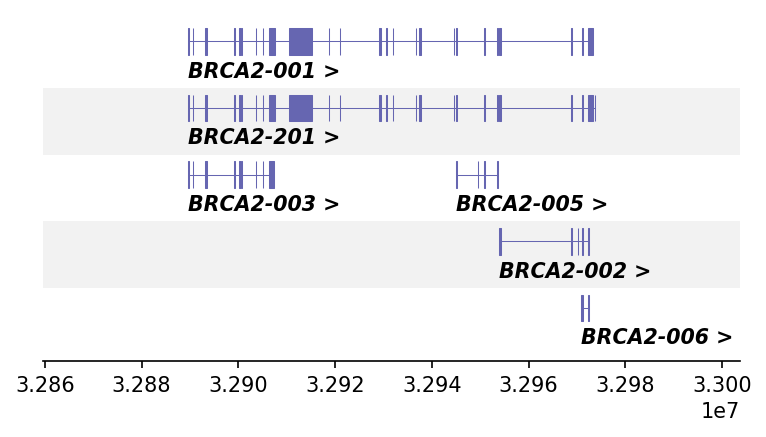

In [43]:
display(gfig)